In [2]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.14.0


In [3]:
SIZE_HIGH = 256
SIZE_LOW = 128
high_img = []
low_img = []

high_res_path = 'cropped_images_training'  # Update with the path to your high-resolution images folder
low_res_path = 'output_folder_training_128'    # Update with the path to your low-resolution images folder

high_res_files = os.listdir(high_res_path)
low_res_files = os.listdir(low_res_path)

for i in tqdm(range(len(high_res_files))):    
    img_high = cv2.imread(os.path.join(high_res_path, high_res_files[i]), 1)
    img_high = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
    img_high = cv2.resize(img_high, (SIZE_HIGH, SIZE_HIGH))
    img_high = img_high.astype('float32') / 255.0
    high_img.append(img_to_array(img_high))

    img_low = cv2.imread(os.path.join(low_res_path, low_res_files[i]), 1)
    img_low = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)
    img_low = cv2.resize(img_low, (SIZE_LOW, SIZE_LOW))
    img_low = img_low.astype('float32') / 255.0
    low_img.append(img_to_array(img_low))


100%|█████████████████████████████████████████████████████████████████████████████| 1744/1744 [00:11<00:00, 158.33it/s]


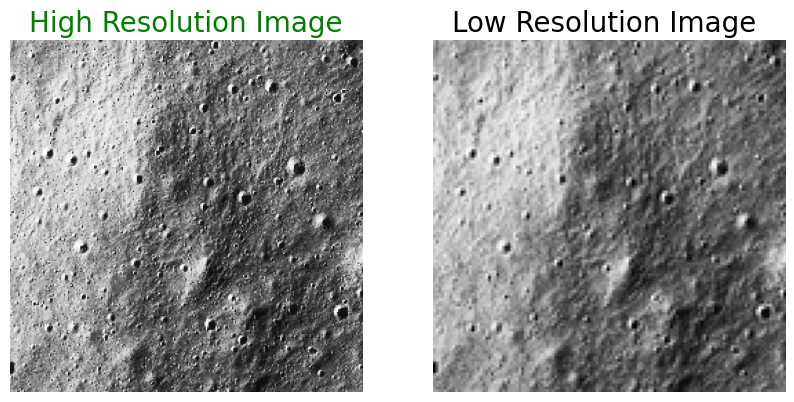

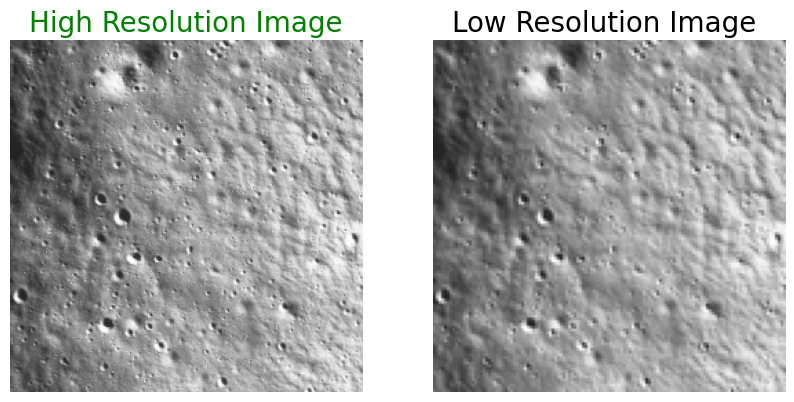

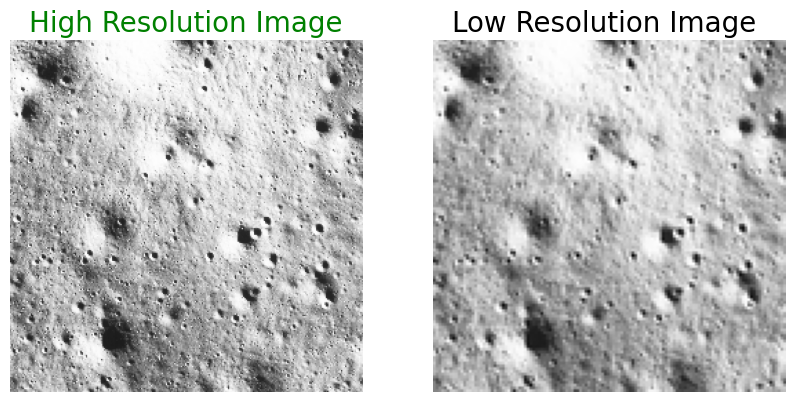

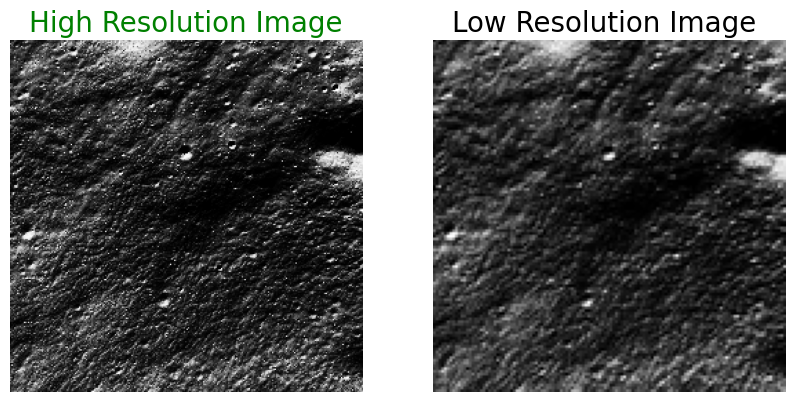

In [4]:
for i in range(4):
    a = np.random.randint(0,1744)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [5]:
train_high_image = high_img[:1200]
train_low_image = low_img[:1200]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE_HIGH,SIZE_HIGH,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE_LOW,SIZE_LOW,3))

validation_high_image = high_img[1200:1400]
validation_low_image = low_img[1200:1400]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE_HIGH,SIZE_HIGH,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE_LOW,SIZE_LOW,3))


test_high_image = high_img[1400:]
test_low_image = low_img[1400:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE_HIGH,SIZE_HIGH,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE_LOW,SIZE_LOW,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

print("Shape of training images:",train_low_image.shape)
print("Shape of test images:",test_low_image.shape)
print("Shape of validation images:",validation_low_image.shape)

Shape of training images: (1200, 256, 256, 3)
Shape of test images: (344, 256, 256, 3)
Shape of validation images: (200, 256, 256, 3)
Shape of training images: (1200, 128, 128, 3)
Shape of test images: (344, 128, 128, 3)
Shape of validation images: (200, 128, 128, 3)


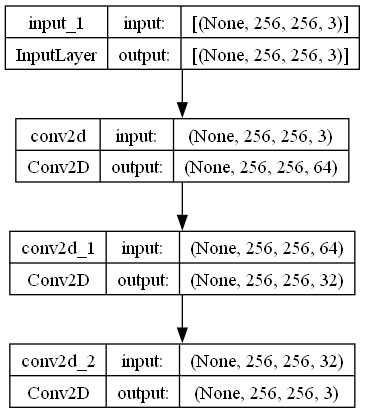

In [6]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, 9, padding='same', activation='relu')(input_img)
l2 = Conv2D(32, 1, padding='same', activation='relu')(l1)
l3 = Conv2D(3, 5, padding='same', activation='relu')(l2)

SRCNN = Model(input_img, l3)

def pixel_mse_loss(x, y):
    return tf.reduce_mean((x - y) ** 2)

SRCNN.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=pixel_mse_loss)
plot_model(SRCNN, to_file='super_res.png', show_shapes=True)

In [6]:
# import tensorflow as tf

# # Resize input images to match the model's input shape
# train_low_image_resized = tf.image.resize(train_low_image, (256, 256))
# validation_low_image_resized = tf.image.resize(validation_low_image, (256, 256))

# # Train the model
# SRCNN.fit(train_low_image_resized, train_high_image, epochs=14, batch_size=1, validation_data=(validation_low_image_resized, validation_high_image))


In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where you want to save the model
checkpoint_path = "srcnn_model.h5"

# Create a ModelCheckpoint callback to save the model
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)

# Resize input images to match the model's input shape with padding
train_low_image_resized = tf.image.resize_with_pad(train_low_image, 256, 256)
validation_low_image_resized = tf.image.resize_with_pad(validation_low_image, 256, 256)

# Train the model
history = SRCNN.fit(train_low_image_resized, train_high_image, epochs=14, batch_size=1, validation_data=(validation_low_image_resized, validation_high_image), callbacks=[model_checkpoint])

# Save the model after training
SRCNN.save("final_srcnn_model.h5")

Epoch 1/14
1200/1200 [==============================] - 169s 140ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 2/14
   1/1200 [..............................] - ETA: 2:36 - loss: 0.0081

C:\Users\arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1200/1200 [==============================] - 163s 135ms/step - loss: 0.0090 - val_loss: 0.0114
Epoch 3/14
1200/1200 [==============================] - 165s 138ms/step - loss: 0.0091 - val_loss: 0.0121
Epoch 4/14
1200/1200 [==============================] - 191s 159ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 5/14
1200/1200 [==============================] - 161s 134ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 6/14
1200/1200 [==============================] - 168s 140ms/step - loss: 0.0090 - val_loss: 0.0114
Epoch 7/14
1200/1200 [==============================] - 168s 140ms/step - loss: 0.0087 - val_loss: 0.0113
Epoch 8/14
1200/1200 [==============================] - 167s 139ms/step - loss: 0.0090 - val_loss: 0.0113
Epoch 9/14
1200/1200 [==============================] - 164s 136ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 10/14
1200/1200 [==============================] - 168s 140ms/step - loss: 0.0087 - val_loss: 0.0118
Epoch 11/14
1200/1200 [==============================] -

In [7]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [8]:
# Assuming test_low_image_resized is a list or array containing the resized low-resolution images
test_low_image_resized = tf.image.resize_with_pad(test_low_image, 256, 256)

# Convert the list/array of images into a NumPy array
test_low_image_resized = np.array(test_low_image_resized)

# Reshape the input data to match the expected input shape of the model
test_low_image_resized = test_low_image_resized.reshape(-1, 256, 256, 3)

# Predict using the model
predicted = SRCNN.predict(test_low_image_resized)

11/11 [==============================] - 6s 480ms/step


1/1 [==============================] - 0s 84ms/step


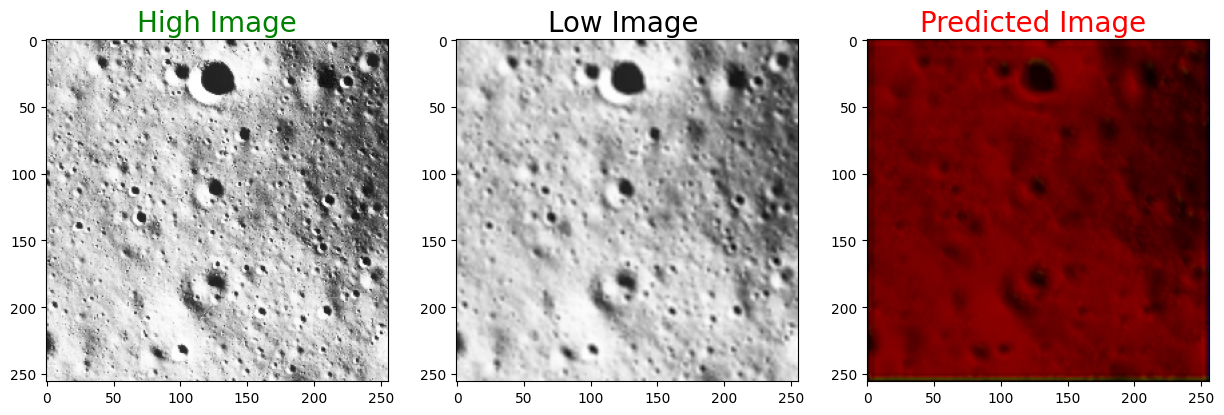

PSNR tf.Tensor(3.873546, shape=(), dtype=float32) dB SSIM tf.Tensor(0.06518065, shape=(), dtype=float32)
1/1 [==============================] - 0s 46ms/step


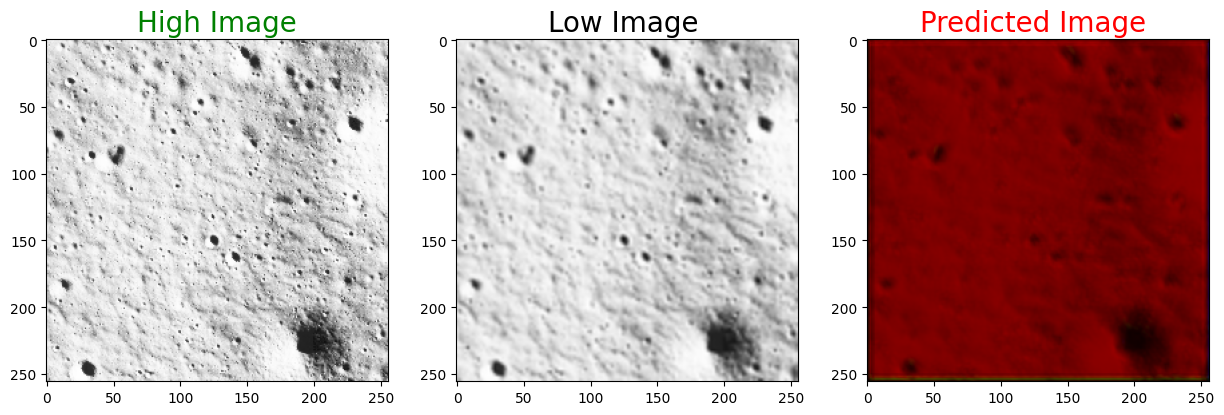

PSNR tf.Tensor(2.918576, shape=(), dtype=float32) dB SSIM tf.Tensor(0.07609466, shape=(), dtype=float32)
1/1 [==============================] - 0s 99ms/step


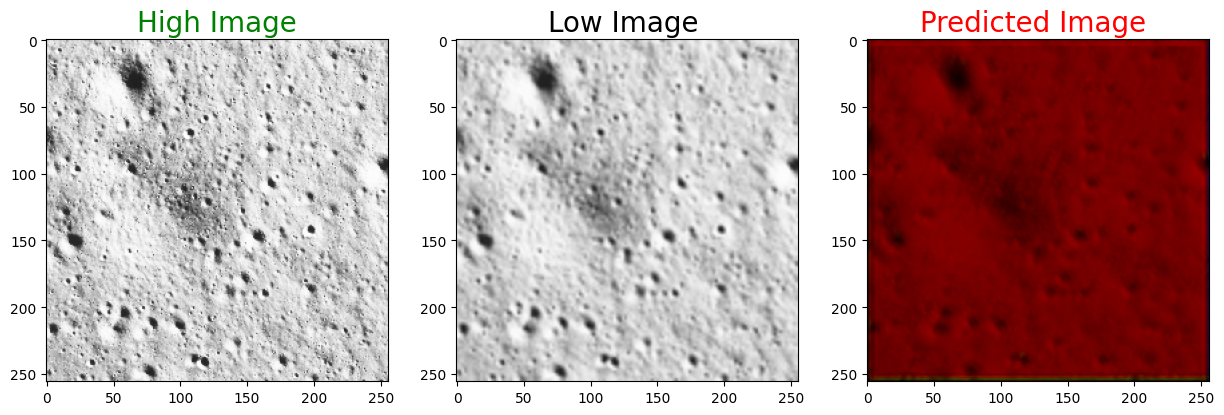

PSNR tf.Tensor(3.2258499, shape=(), dtype=float32) dB SSIM tf.Tensor(0.061385456, shape=(), dtype=float32)
1/1 [==============================] - 0s 91ms/step


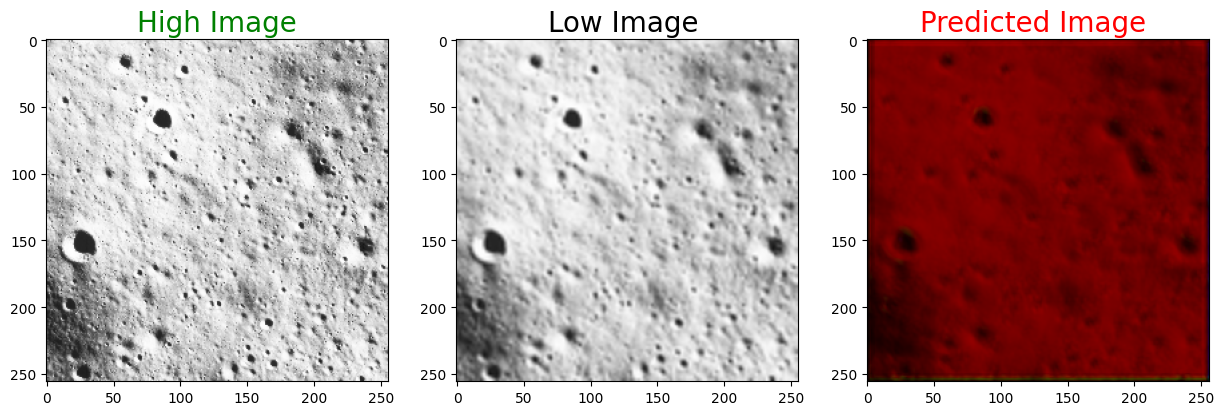

PSNR tf.Tensor(3.3650575, shape=(), dtype=float32) dB SSIM tf.Tensor(0.06797528, shape=(), dtype=float32)
1/1 [==============================] - 0s 69ms/step


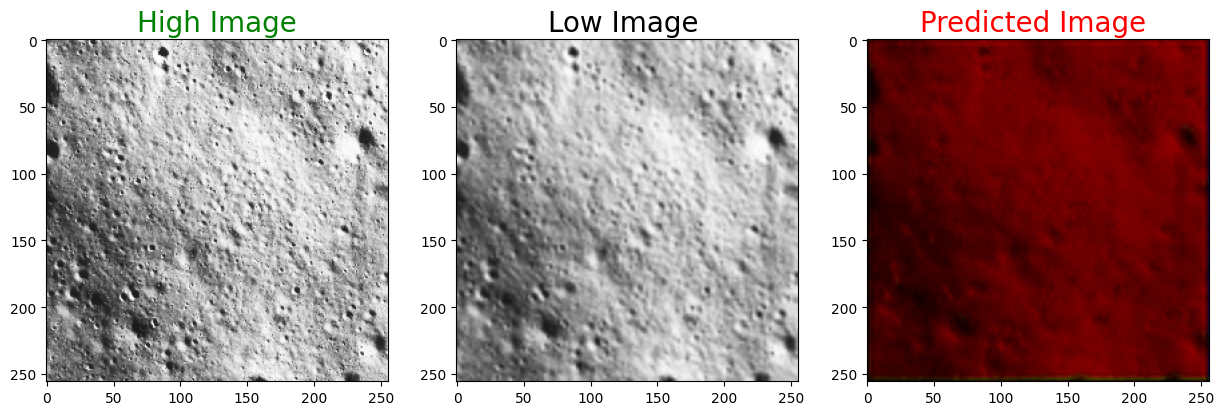

PSNR tf.Tensor(4.5824924, shape=(), dtype=float32) dB SSIM tf.Tensor(0.051788714, shape=(), dtype=float32)
1/1 [==============================] - 0s 60ms/step


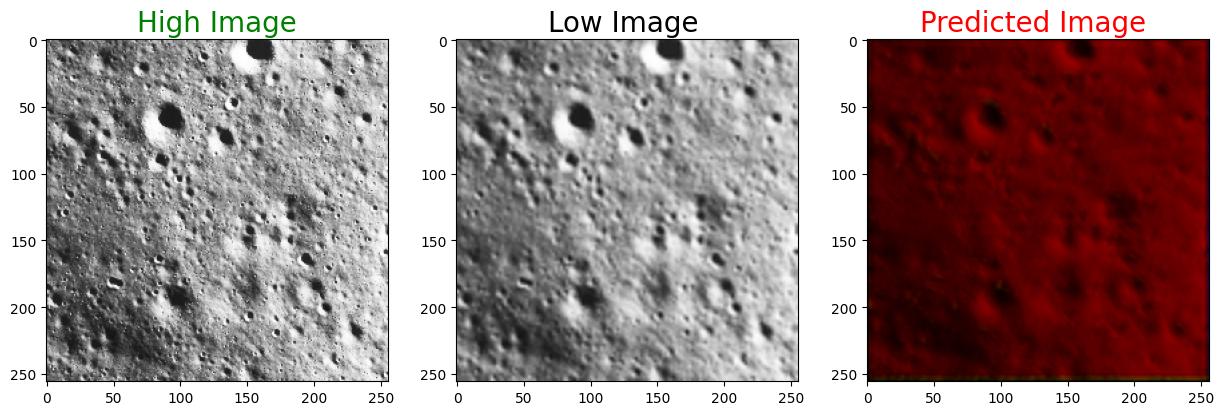

PSNR tf.Tensor(5.5210466, shape=(), dtype=float32) dB SSIM tf.Tensor(0.05908448, shape=(), dtype=float32)
1/1 [==============================] - 0s 63ms/step


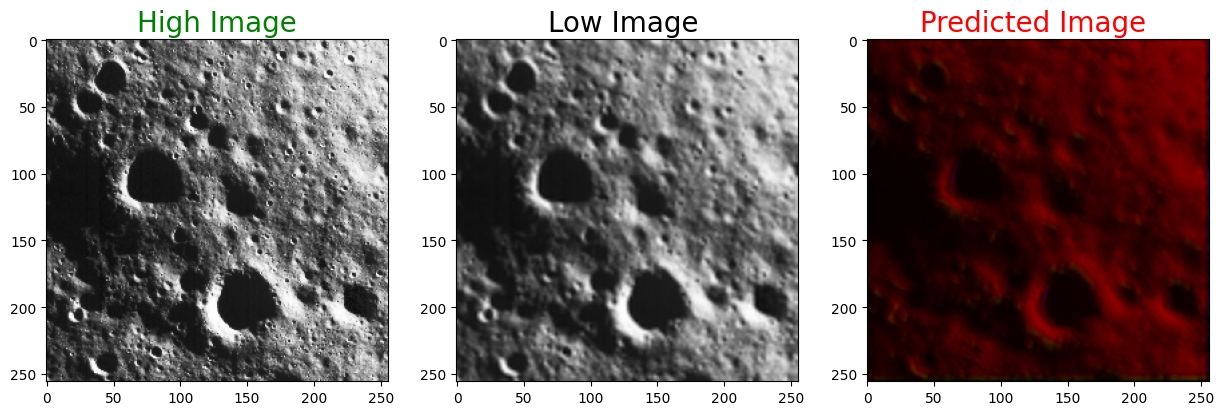

PSNR tf.Tensor(7.9656677, shape=(), dtype=float32) dB SSIM tf.Tensor(0.09382257, shape=(), dtype=float32)
1/1 [==============================] - 0s 83ms/step


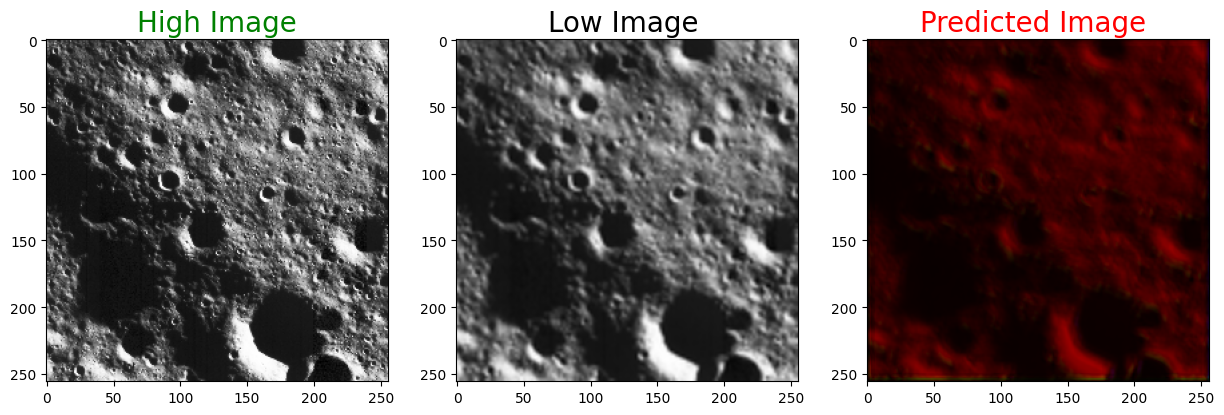

PSNR tf.Tensor(9.150955, shape=(), dtype=float32) dB SSIM tf.Tensor(0.102371596, shape=(), dtype=float32)
1/1 [==============================] - 0s 99ms/step


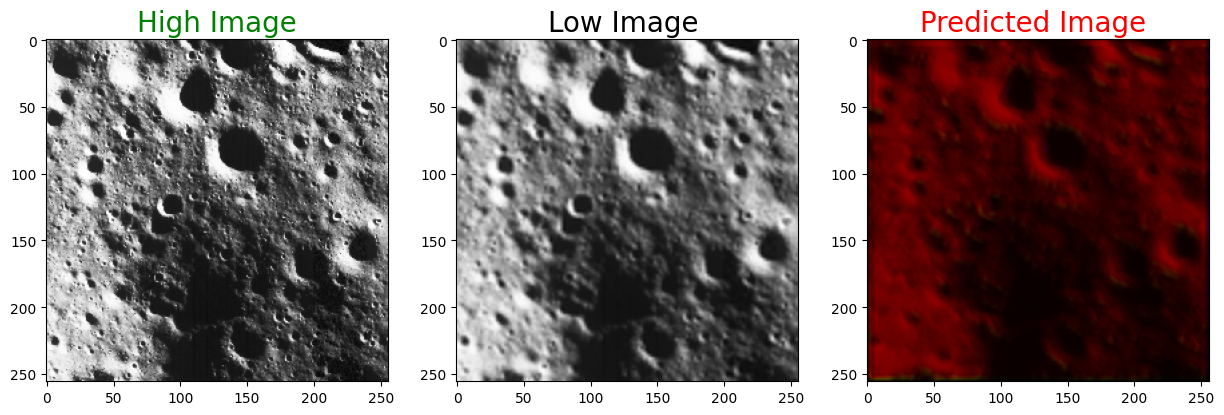

PSNR tf.Tensor(7.2492437, shape=(), dtype=float32) dB SSIM tf.Tensor(0.08950428, shape=(), dtype=float32)


In [9]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(16,25):
    
    predicted = np.clip(SRCNN.predict(test_low_image_resized[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(test_high_image[i],test_low_image_resized[i],predicted)
    print('PSNR',PSNR(test_high_image[i],predicted),'dB', "SSIM",tf.image.ssim(test_high_image[i],predicted,max_val=1))

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

# Define the custom loss function
def pixel_mse_loss(x, y):
    return tf.reduce_mean((x - y) ** 2)

# Load the SRCNN model within a custom object scope
with tf.keras.utils.custom_object_scope({'pixel_mse_loss': pixel_mse_loss}):
    srcnn_model = tf.keras.models.load_model('final_srcnn_model.h5')

# Function to compute PSNR
def compute_psnr(hr_img, sr_img):
    mse = np.mean((hr_img - sr_img) ** 2)
    max_val = np.max(hr_img)
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

# Function to compute SSIM
def compute_ssim(hr_img, sr_img):
    return ssim(hr_img, sr_img, multichannel=True)

# Load the dataset (HR images)
hr_images_path = 'cropped_images_training'
hr_images = np.array([cv2.imread(os.path.join(hr_images_path, img)) for img in os.listdir(hr_images_path)])

# Load the dataset (LR images)
lr_images_path = 'output_folder_training_128'
lr_images = np.array([cv2.imread(os.path.join(lr_images_path, img)) for img in os.listdir(lr_images_path)])
lr_images_resized = tf.image.resize_with_pad(lr_images, 256, 256)

# Generate SR images using the SRCNN model
sr_images = srcnn_model.predict(lr_images_resized)

# Calculate PSNR and SSIM for each pair of HR and SR images
psnr_values = []
ssim_values = []

for hr_img, sr_img in zip(hr_images, sr_images):
    # Compute PSNR
    psnr_val = compute_psnr(hr_img, sr_img)
    psnr_values.append(psnr_val)
    
    # Compute SSIM
    ssim_val = compute_ssim(hr_img, sr_img)
    ssim_values.append(ssim_val)

# Save PSNR and SSIM values to a file
output_file = 'psnr_ssim_results.txt'
with open(output_file, 'w') as f:
    f.write('Image_Name\tPSNR\tSSIM\n')
    for img_name, psnr_val, ssim_val in zip(os.listdir(hr_images_path), psnr_values, ssim_values):
        f.write(f'{img_name}\t{psnr_val}\t{ssim_val}\n')
